<a href="https://colab.research.google.com/github/paulynamagana/afdb-api-course/blob/main/2_afdb_data_analysis_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#02CCFE'> Exploring AlphaFold Data: Statistics and Visualisation </font>

In the previous session, we learned how to programmatically access and download predicted protein structures and associated files from the AlphaFold Database. This notebook builds upon that foundation by demonstrating how to extract meaningful insights and visualise key quality metrics from AlphaFold Database predictions.

Beyond merely retrieving files, understanding the quality and confidence of AlphaFold models is crucial for their effective application in research. Two primary metrics provided by AlphaFold are particularly important for this:

* Predicted Local Distance Difference Test (pLDDT): This per-residue metric estimates the confidence of AlphaFold's prediction at each amino acid position. A higher pLDDT score (typically on a scale of 0-100) indicates higher confidence in the local structure.

* Predicted Aligned Error (PAE): The PAE provides an estimate of the expected positional error at different residues after optimal superposition of the predicted structure. This 2D matrix helps assess the relative confidence of domains and how well they are predicted to be positioned relative to each other. Lower PAE values indicate higher confidence in the relative positions.

## Objectives
By the end of this Colab notebook, you will be able to:

* Parse and extract numerical data (e.g., pLDDT scores, sequence lengths, PAE values) from AlphaFold API responses.
* Calculate descriptive statistics such as minimum, maximum, and average pLDDT for a given protein entry.
* Determine the minimum and maximum Predicted Aligned Error (PAE) distances.
* Visualise relationships between data points, such as plotting sequence length against average pLDDT or visualising pLDDT scores along the protein sequence.
* Utilise Python libraries for data manipulation and plotting to gain deeper insights into protein models.

In [1]:
#Run this code to install gemmi

!pip install gemmi

In [2]:
import requests
import json
import gemmi

# This function is adapted from the previous Google Colab notebook to fetch data from the AlphaFold Database API.

def get_alphafold_entry_details(uniprot_id):
  """
  Fetches prediction data for a given UniProt ID from the AlphaFold Database API
  and extracts relevant URLs (cifUrl, amAnnotationsUrl).

  Args:
    uniprot_id (str): The UniProt accession ID for the protein of interest (e.g., "P12345").

  Returns:
    dict or None: A dictionary containing 'cifUrl' and 'amAnnotationsUrl' if the request
                  is successful and data is found. Returns None if the request fails
                  due to network issues, an unsuccessful status code, or no data.
  """

  AFDB_API_URL = url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
  try:
    print(f"Fetching data for {uniprot_id}")
    response = requests.get(AFDB_API_URL, timeout=10)
    if response.status_code == 200: # Check if the HTTP request was successful (status code 200 means OK)
        result = response.json()
        print(f"Success! Received data for {uniprot_id}")

        entryt = result[0]

        return { # Return a dictionary with specific URLs
            "cifUrl": entryt["cifUrl"],
            "amAnnotationsUrl": entryt["amAnnotationsUrl"],
        }

    else:
      print(f"⚠️ No data entries found in the API response for {uniprot_id}.")
      if response.status_code == 404 or response.status_code == 400:
        print(f"Error, please check ID for {uniprot_id}")
  except requests.exceptions.RequestException as e:
    print(f"Error fetching data for {uniprot_id}: {e}")
    return None



def _parse_plddt_from_cif(cif_url):
  """
  Downloads the mmCIF file content from the given URL and then parses
  pLDDT (Predicted Local Distance Difference Test) scores from it.
  pLDDT scores are a per-residue measure of confidence in AlphaFold's prediction.

  Args:
    cif_url (str): The URL to the mmCIF file.

  Returns:
    list: A list of dictionaries, where each dictionary contains the 'residue_number'
          and its corresponding 'plddt' score. Returns an empty list if download or parsing fails
          or no pLDDT scores are found.
  """
  plddt_scores = [] #start an empty list
  cif_content = None

  if not cif_url or cif_url.startswith("Error"):
      print("Invalid or missing CIF URL provided. Cannot download or parse pLDDT.")
      return []

  try:
    print(f"Downloading CIF content from {cif_url}...")
    cif_response = requests.get(cif_url, timeout=30) # Download the CIF file content
    if cif_response.status_code == 200:
          cif_content = cif_response.text # Get the content as a string
          print("CIF content downloaded successfully.")

    doc = gemmi.cif.read_string(cif_content)
    block = doc.sole_block()

    res_number_strs = block.find_values("_ma_qa_metric_local.label_seq_id")
    plddt_value_strs = block.find_values("_ma_qa_metric_local.metric_value")

    if not res_number_strs or not plddt_value_strs:
      print("Could not find pLDDT tags or valued in CIF")
      return []

    if len(res_number_strs) != len(plddt_value_strs):
      print(f"Mismatch in length of residues ({len(res_number_strs)}) and pLDDT values ({len(plddt_value_strs)})")
      return []

    for res_number_strs, plddt_str in zip(res_number_strs, plddt_value_strs):
      try:
        plddt_scores.append({
            "residue_number": int(res_number_strs),
            "plddt": float(plddt_str)
        })
      except ValueError as e_val:
        print("e_val")

    if not plddt_scores:
      print("No pLDDT scores found")
      return []

  except Exception as e:
    print(f"Error parsing CIF: {e}")
  return plddt_scores

In [3]:
uniprot_id = "Q5VSL9" #@param{type:"string"}
uniprot_id = uniprot_id.upper()

In [4]:
# -- Example with printed plddt scores
entry_details = get_alphafold_entry_details(uniprot_id)
cif_url = entry_details.get("cifUrl")
plddt_scores = _parse_plddt_from_cif(cif_url)
print(plddt_scores)

Fetching data for Q5VSL9
Success! Received data for Q5VSL9
CIF content downloaded successfully.
[{'residue_number': 1, 'plddt': 39.15}, {'residue_number': 2, 'plddt': 37.73}, {'residue_number': 3, 'plddt': 46.58}, {'residue_number': 4, 'plddt': 38.07}, {'residue_number': 5, 'plddt': 43.19}, {'residue_number': 6, 'plddt': 41.76}, {'residue_number': 7, 'plddt': 41.86}, {'residue_number': 8, 'plddt': 40.49}, {'residue_number': 9, 'plddt': 36.47}, {'residue_number': 10, 'plddt': 41.04}, {'residue_number': 11, 'plddt': 35.11}, {'residue_number': 12, 'plddt': 37.3}, {'residue_number': 13, 'plddt': 36.67}, {'residue_number': 14, 'plddt': 35.43}, {'residue_number': 15, 'plddt': 35.47}, {'residue_number': 16, 'plddt': 38.94}, {'residue_number': 17, 'plddt': 38.36}, {'residue_number': 18, 'plddt': 41.32}, {'residue_number': 19, 'plddt': 46.34}, {'residue_number': 20, 'plddt': 45.31}, {'residue_number': 21, 'plddt': 52.54}, {'residue_number': 22, 'plddt': 53.04}, {'residue_number': 23, 'plddt': 5

In [5]:
# Calculate statistics
plddt_values_only = [item['plddt'] for item in plddt_scores]
min_plddt = min(plddt_values_only)
max_plddt = max(plddt_values_only)
average_plddt = sum(plddt_values_only) / len(plddt_values_only)

print(f"\n--- pLDDT Statistics for {uniprot_id} ---")
print(f"Minimum pLDDT: {min_plddt:.2f}")
print(f"Maximum pLDDT: {max_plddt:.2f}")
print(f"Average pLDDT: {average_plddt:.2f}")


--- pLDDT Statistics for Q5VSL9 ---
Minimum pLDDT: 25.44
Maximum pLDDT: 98.81
Average pLDDT: 80.82


# <font color='#e59454'> 1.  Plot plddt scores </font>

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from matplotlib.patches import Rectangle # Used to draw rectangular patches on a plot

def plot_plddt(plddt_data, output_path, file_name):
    """
    Plots pLDDT scores along the protein sequence with background confidence regions
    and saves the plot to a specified file.

    Parameters:
    - plddt_data (list of dict): A list of dictionaries, where each dictionary
                                 contains 'residue_number' and 'plddt' score.
                                 Example: [{'residue_number': 1, 'plddt': 85.2}, ...]
    - output_path (str): The directory where the plot image will be saved.
    - file_name (str): The base name for the output plot file (e.g., "Q5VSL9").
    """
    # Extract residue numbers and pLDDT values from the list of dictionaries
    residue_numbers = [item['residue_number'] for item in plddt_data]
    plddt_values = [item['plddt'] for item in plddt_data]

    # Create the plot figure and axes
    fig, ax = plt.subplots(figsize=(12, 5)) # Set figure size for better readability

    # Define pLDDT confidence regions as rectangles in the background
    total_residues = len(plddt_values) # The total length of the protein sequence

    # Very high confidence region (pLDDT > 90) - Dark Blue
    ax.add_patch(Rectangle((0, 90), total_residues, 10, color="#024fcc", alpha=0.3, label="Very high (pLDDT > 90)"))
    # Confident region (70 < pLDDT <= 90) - Light Blue
    ax.add_patch(Rectangle((0, 70), total_residues, 20, color="#60c2e8", alpha=0.3, label="Confident (70 < pLDDT <= 90)"))
    # Low confidence region (50 < pLDDT <= 70) - Yellow
    ax.add_patch(Rectangle((0, 50), total_residues, 20, color="#f9d613", alpha=0.3, label="Low (50 < pLDDT <= 70)"))
    # Very low confidence region (pLDDT <= 50) - Orange
    ax.add_patch(Rectangle((0, 0), total_residues, 50, color="#FF7D45", alpha=0.3, label="Very low (pLDDT <= 50)"))

    # Plot the pLDDT scores as a line plot
    # x-axis: residue numbers, y-axis: pLDDT values
    sns.lineplot(x=residue_numbers, y=plddt_values, ax=ax, color="black", linewidth=1.0)

    ax.set_xlabel('Residue Number', fontsize=12)
    ax.set_ylabel('pLDDT Score', fontsize=12)
    ax.set_title(f'Predicted Local Distance Difference Test (pLDDT) Scores for {file_name}', fontsize=14)
    ax.spines[["right", "top"]].set_visible(False) # Hide the top and right plot borders

    ax.set_xlim(min(residue_numbers) - 1, max(residue_numbers) + 1)
    ax.set_ylim(0, 100)
    ax.margins(x=0.01)

    # Add legend to explain confidence regions
    ax.legend(title="pLDDT Confidence", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Save the plot to a file
    output_file = os.path.join(output_path, f"{file_name}_pLDDT.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"pLDDT plot saved to {output_file}")
    plt.show()
    plt.close(fig)

Mounted at /content/drive
pLDDT plot saved to /content/drive/MyDrive/AFDB_API_course_downloads/Q5VSL9_pLDDT.png


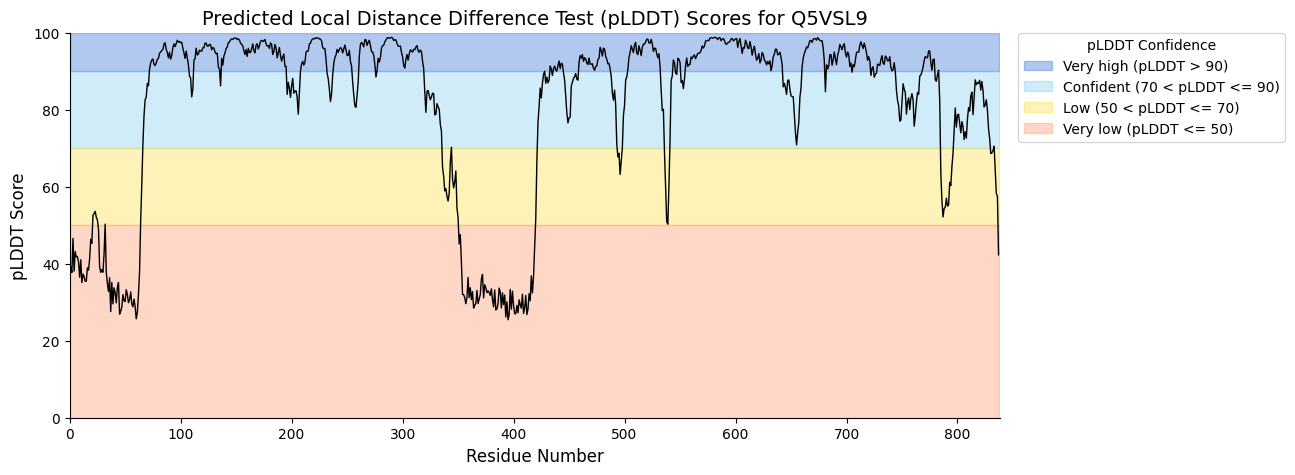

In [9]:
# -- Mount Google Drive
drive.mount('/content/drive', force_remount=True) # this will mount you Google Drive
destination_path = "/content/drive/MyDrive/AFDB_API_course_downloads"

plot_plddt(plddt_scores, destination_path, uniprot_id)